In this notebook I will try to find a possible customer segmenetation enabling to classify customers according the their different purchases. I hope this information will be useful for the next prediction task. Since there are thousands of products in the dataset I will rely on aisles, which represent categories of products. Even with aisles features will be too much so I will use Principal Component Analysis to find new dimensions along which clustering will be easier. I will then try to find possible explanations for the identified clusters.

First Exploration

Data Dictionary:
https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b

Market Basket Analysis data (Kaggle):
https://www.kaggle.com/c/instacart-market-basket-analysis/data

Instacart Data (public release - article):
https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2

Citation to add to notebook:
“The Instacart Online Grocery Shopping Dataset 2017”, Accessed from https://www.instacart.com/datasets/grocery-shopping-2017
    
PCA-using-python-scikit-learn : https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

Customer segments with PCA: https://www.kaggle.com/asindico/customer-segments-with-pca
    
Step By Step PCA Math: https://builtin.com/data-science/step-step-explanation-principal-component-analysis

In [1]:
import numpy as np 
import pandas as pd

In [2]:
import os
os.chdir("D:\WorkRepo\instacart-market-basket-analysis\instacart-market-basket-analysis")

In [10]:
orders = pd.read_csv('orders.csv')
prior = pd.read_csv('order_products__prior.csv')

In [11]:
orders.groupby(orders['eval_set']).count()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
eval_set,,,,,,
prior,3214874,3214874,3214874,3214874,3214874,3008665
test,75000,75000,75000,75000,75000,75000
train,131209,131209,131209,131209,131209,131209


In [18]:
prior.count()
# prior dataset contains more records than order dataset - we can take care of this when joining the two datasets

order_id             32434489
product_id           32434489
add_to_cart_order    32434489
reordered            32434489
dtype: int64

In [16]:
# Where is my file? Find save location
# https://stackoverflow.com/questions/18901185/ipython-notebook-save-location
#!ipython locate
# Default: C:\Users\Vineet PC\.ipython


C:\Users\Vineet PC\.ipython


In [19]:
##Due to the number of rows I have to reduce the set of prior data to publish the kernel 
##comment this if you execute it on your local machine
prior = prior[0:300000]

Merge two datasets

In [20]:
order_prior = pd.merge(prior,orders,on=['order_id','order_id'])
order_prior = order_prior.sort_values(by=['user_id','order_id'])
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
221645,23391,13198,1,1,7,prior,17,0,10,28.0
221646,23391,42803,2,1,7,prior,17,0,10,28.0
221647,23391,8277,3,1,7,prior,17,0,10,28.0
221648,23391,37602,4,1,7,prior,17,0,10,28.0
221649,23391,40852,5,1,7,prior,17,0,10,28.0


In [21]:
order_prior.count()

order_id                  300000
product_id                300000
add_to_cart_order         300000
reordered                 300000
user_id                   300000
eval_set                  300000
order_number              300000
order_dow                 300000
order_hour_of_day         300000
days_since_prior_order    280806
dtype: int64

In [22]:
print(order_prior.shape)

(300000, 10)


Now loading Products and Aisles datasets and merging them with order_prior

In [23]:
products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')

In [26]:
products.count()

product_id       49688
product_name     49688
aisle_id         49688
department_id    49688
dtype: int64

In [24]:
data = pd.merge(prior,products, on = ['product_id','product_id'])
data = pd.merge(data,orders,on=['order_id','order_id'])
data = pd.merge(data,aisles,on=['aisle_id','aisle_id'])
data.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,eggs
1,26,33120,5,0,Organic Egg Whites,86,16,153404,prior,2,0,16,7.0,eggs
2,120,33120,13,0,Organic Egg Whites,86,16,23750,prior,11,6,8,10.0,eggs
3,327,33120,5,1,Organic Egg Whites,86,16,58707,prior,21,6,9,8.0,eggs
4,390,33120,28,1,Organic Egg Whites,86,16,166654,prior,48,0,12,9.0,eggs
5,537,33120,2,1,Organic Egg Whites,86,16,180135,prior,15,2,8,3.0,eggs
6,582,33120,7,1,Organic Egg Whites,86,16,193223,prior,6,2,19,10.0,eggs
7,608,33120,5,1,Organic Egg Whites,86,16,91030,prior,11,3,21,12.0,eggs
8,623,33120,1,1,Organic Egg Whites,86,16,37804,prior,63,3,12,3.0,eggs
9,689,33120,4,1,Organic Egg Whites,86,16,108932,prior,16,1,13,3.0,eggs


In [25]:
data.shape

(300000, 14)

In [ ]:
# Sneakpeak into product names in products dataset
data['product_name'].value_counts()[0:10]

In [30]:
# Count of unique products in the dataset
len(data['product_name'].unique())

24836

In [32]:
# Sneakpeak into aisle names in aisles dataset
data['aisle'].value_counts()[0:10]

fresh fruits                     33755
fresh vegetables                 31004
packaged vegetables fruits       16319
yogurt                           13477
packaged cheese                   9133
milk                              8254
water seltzer sparkling water     7634
chips pretzels                    6581
soy lactosefree                   5965
bread                             5457
Name: aisle, dtype: int64

**Principal Component Analysis**

Reading [1] and [2] we got to know that we can speed up the fitting of a machine learning algorithm by changing the optimization algorithm. A more common way of speeding up a machine learning algorithm is by using Principal Component Analysis (PCA). If your learning algorithm is too slow because the input dimension is too high, then using PCA to speed it up can be a reasonable choice. This is probably the most common application of PCA. Another common application of PCA is for data visualization.

SKLEARN PCA Library:
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html


References:
[1]: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
[2]: https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a


In order to determine possible clusters among the customers, single user_id will need to be substituted with the specific cluster to which they are assumed to belong. Fro this I will create a crosstab of user_id with **aisle** (representing product category).

This should perhaps eventually increase the next prediction model performance.

 -> Creating a dataframe with all the purchases made by each user

In [43]:

cust_prod = pd.crosstab(data['user_id'], data['aisle'])
cust_prod.head(10)
#cust_prod.shape

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,4
27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,4
36,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
66,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
70,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Applying PCA from SKLEARN

In [38]:
# !pip install sklearn

  Using cached threadpoolctl-2.1.0-py3-none-any.whl (12 kB)
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1321 sha256=b70bab0ede83657255064a5b829fedfa154db743b2dd7b9330d4c0e4a68d62f0
  Stored in directory: c:\users\vineet pc\appdata\local\pip\cache\wheels\22\0b\40\fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn


In [55]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(cust_prod)
pca_samples = pca.transform(cust_prod)

In [56]:
#type(pca_samples)
pca_samples = pd.DataFrame(pca_samples, columns = ['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6'])

In [57]:
pca_samples.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6
0,-0.286251,1.005868,-1.030292,-0.898964,-0.587675,-0.998982
1,-1.972748,-0.487659,-0.120541,0.213091,0.045931,-0.182132
2,-1.168974,1.284089,3.228124,0.594045,-0.648822,-1.091778
3,-1.433967,1.250081,3.261985,1.237737,-0.353525,-0.346412
4,-2.070709,-0.422148,-0.101553,0.278129,0.005933,-0.097450


Visualizing the principal components (PC2 and PC5)

(25831, 2)
        PC5       PC2
0 -0.587675  1.005868
1  0.045931 -0.487659
2 -0.648822  1.284089
3 -0.353525  1.250081
4  0.005933 -0.422148


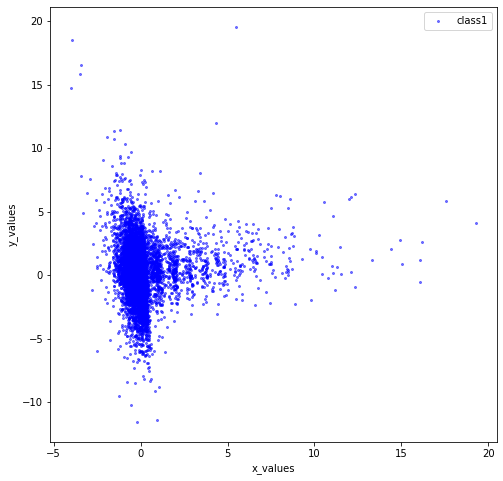

In [60]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
tocluster = pd.DataFrame(pca_samples[['PC5','PC2']])
print (tocluster.shape)
print (tocluster.head())

fig = plt.figure(figsize=(8,8))
plt.plot(tocluster['PC5'], tocluster['PC2'], 'o', markersize=2, color='blue', alpha=0.5, label='class1')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [61]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

clusterer = KMeans(n_clusters=4,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
print(centers)

[[-0.04620596 -0.15279047]
 [-0.00851022 -2.39783038]
 [-0.24921441  2.06678283]
 [ 5.57233012  1.45511416]]


In [62]:
print (c_preds[0:100])

[2 0 2 2 0 0 0 0 0 0 1 0 2 0 0 3 0 0 2 0 0 0 0 0 0 2 1 0 0 2 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 2 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0
 2 2 1 0 0 0 0 0 2 2 0 0 1 2 0 0 0 0 0 2 0 0 2 0 0 0]


Visualizing the clusters

['purple', 'orange', 'purple', 'purple', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange']


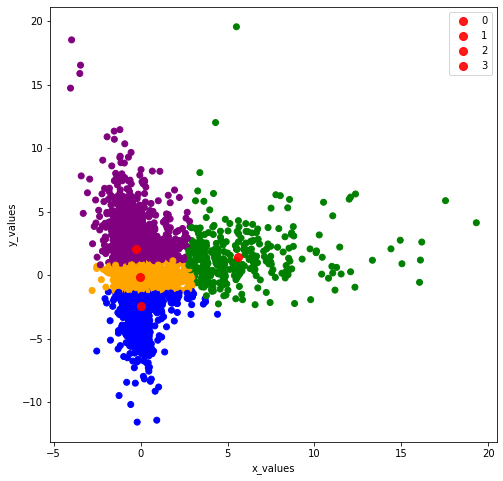

In [64]:
import matplotlib
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','purple','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster['PC5'],tocluster['PC2'],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

We have found a possible clustering for our customers. Let's check if we also manage to find some interesting pattern beneath it.

In [72]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

clust_prod.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,4,0
27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,4,0
36,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
66,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
70,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


See the shape of our product-clustrers dataframe for Cluster # 0

In [97]:
clust_prod[clust_prod['cluster']==0]
# 16294 rows × 135 columns

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,4,0
27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,4,0
36,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206162,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0
206165,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
206201,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Creating subplots (2 X 2) = 4

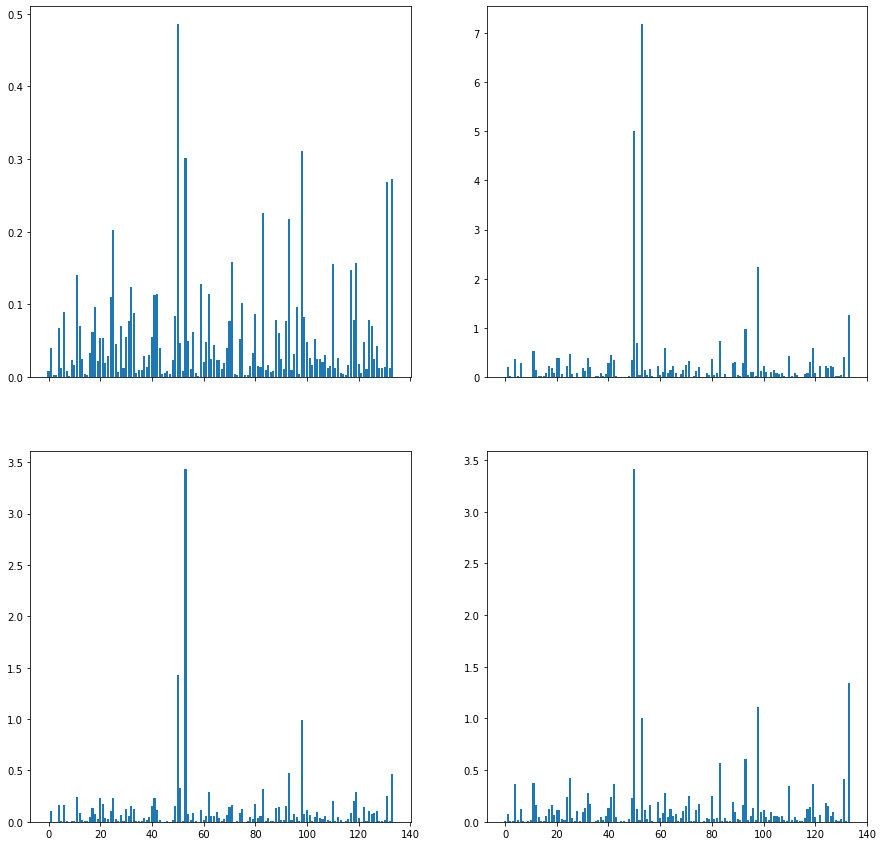

In [100]:
# Subplots structure
f,arr = plt.subplots(2,2,sharex=True,figsize=(15,15))

# Size of data (count of records) for Cluster number = 0
#c1_count = len(clust_prod[clust_prod['cluster']==0])

# Average number of records (customers) in each product category for Cluster number = 0
c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()

# In subplot (# 0,0), plot Average number of customers in each product category in Cluster number = 0
# Using bargraph
arr[0,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c0)

# Average number of records (customers) in each product category for Cluster number = 1
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()

# In subplot (# 0,1), plot Average number of customers in each product category in Cluster number = 1
# Using bargraph
arr[0,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c1)

# Cluster 2
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()
arr[1,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c2)

# Cluster 3
c3 = clust_prod[clust_prod['cluster']==3].drop('cluster',axis=1).mean()
arr[1,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c3)

plt.show()


1. What are the top 10 items in each cluster?

In [163]:
c0.nlargest(10)
#c1.nlargest(10)
#c2.nlargest(10)
#c3.nlargest(10)

aisle
fresh fruits                     0.485884
packaged vegetables fruits       0.311157
fresh vegetables                 0.301706
yogurt                           0.272677
water seltzer sparkling water    0.268381
milk                             0.225175
packaged cheese                  0.216890
chips pretzels                   0.201853
ice cream ice                    0.158218
soy lactosefree                  0.157543
dtype: float64

2. What are the top 10 items in all clusters combined?

To find this out, we combine all the cluser averages dataseries, group by their indicies keeping only the first occurances thereby eliminating the duplicates in the combined series, and finally keeping the top 10

In [147]:
cp = c0.append(c1)
cp = cp.append(c2)
cp = cp.append(c3)
cp
# This obviously contains duplicates - indices could be the same, however averages may differ among clusters

aisle
air fresheners candles           0.008347
asian foods                      0.040015
baby accessories                 0.002148
baby bath body care              0.002639
baby food formula                0.067203
                                   ...   
trash bags liners                0.012523
vitamins supplements             0.025046
water seltzer sparkling water    0.414425
white wines                      0.004870
yogurt                           1.345083
Length: 536, dtype: float64

In [150]:
cp = cp.groupby(cp.index).first()

3. cluster analysis confirms the initial hypothesis that below products are genereically bought by the majority of the customers.

In [159]:
cp.nlargest(8)

aisle
fresh fruits                     0.485884
packaged vegetables fruits       0.311157
fresh vegetables                 0.301706
yogurt                           0.272677
water seltzer sparkling water    0.268381
milk                             0.225175
packaged cheese                  0.216890
chips pretzels                   0.201853
dtype: float64

4. Let us inspect if the clusters differ in quantities and proportions, with respect to the product categories, or if a cluster is characterized by some goods not included in this list. For instance we can already see cluster 3 is most characterized by 'Fresh Fruits' whereas most of the other clusters are characterized by 'Fresh Vegetables'.

In [158]:
from IPython.display import display, HTML
cluster_means = [[c0['fresh fruits'],c0['fresh vegetables'],c0['packaged vegetables fruits'], c0['yogurt'], c0['packaged cheese'], c0['milk'],c0['water seltzer sparkling water'],c0['chips pretzels']],
                 [c1['fresh fruits'],c1['fresh vegetables'],c1['packaged vegetables fruits'], c1['yogurt'], c1['packaged cheese'], c1['milk'],c1['water seltzer sparkling water'],c1['chips pretzels']],
                 [c2['fresh fruits'],c2['fresh vegetables'],c2['packaged vegetables fruits'], c2['yogurt'], c2['packaged cheese'], c2['milk'],c2['water seltzer sparkling water'],c2['chips pretzels']],
                 [c3['fresh fruits'],c3['fresh vegetables'],c3['packaged vegetables fruits'], c3['yogurt'], c3['packaged cheese'], c3['milk'],c3['water seltzer sparkling water'],c3['chips pretzels']]]
cluster_means = pd.DataFrame(cluster_means, columns = ['fresh fruits','fresh vegetables','packaged vegetables fruits','yogurt','packaged cheese','milk','water seltzer sparkling water','chips pretzels'])
HTML(cluster_means.to_html())

,fresh fruits,fresh vegetables,packaged vegetables fruits,yogurt,packaged cheese,milk,water seltzer sparkling water,chips pretzels
0,0.485884,0.301706,0.311157,0.272677,0.216890,0.225175,0.268381,0.201853
1,4.998037,7.183513,2.247301,1.256133,0.971541,0.738960,0.410206,0.460255
2,1.430813,3.436757,0.991441,0.464574,0.476700,0.323348,0.251070,0.236091
3,3.415353,1.000232,1.110622,1.345083,0.603896,0.573284,0.414425,0.424397


In [164]:
cluster_perc = cluster_means.iloc[:, :].apply(lambda x: (x / x.sum())*100,axis=1)
HTML(cluster_perc.to_html())

,fresh fruits,fresh vegetables,packaged vegetables fruits,yogurt,packaged cheese,milk,water seltzer sparkling water,chips pretzels
0,21.275967,13.211147,13.625003,11.940018,9.497192,9.859988,11.751901,8.838784
1,27.362596,39.327352,12.303229,6.876914,5.318863,4.045560,2.245742,2.519744
2,18.799788,45.156353,13.026772,6.104152,6.263472,4.248540,3.298866,3.102059
3,38.429623,11.254632,12.496738,15.134909,6.795052,6.450603,4.663118,4.775325


5. Above table depicts the percentage of these products with respect to the other top 8 in each cluster. We can see some interesting differences among the clusters.

- It seems that customers in cluster 2 buy more fresh vegetables than those in other clusters.
- Customers in cluster 3 buy more fresh fruits and yogurt than those in the other clusters.

Lets look at the 8th to 15th most bought products for each cluster. These will not include the generic products (i.e. vegetables, fruits, water, etc.) so we may find somthing interesting.

In [168]:
c0.sort_values(ascending=False)[8:15]

aisle
ice cream ice      0.158218
soy lactosefree    0.157543
refrigerated       0.155701
soft drinks        0.147048
bread              0.141095
frozen meals       0.127470
crackers           0.124340
dtype: float64

In [169]:
c1.sort_values(ascending=False)[8:15]

aisle
soy lactosefree                  0.582924
bread                            0.521099
chips pretzels                   0.460255
eggs                             0.439647
refrigerated                     0.420020
water seltzer sparkling water    0.410206
canned meals beans               0.393523
dtype: float64

In [170]:
c2.sort_values(ascending=False)[8:15]

aisle
frozen produce                   0.290300
water seltzer sparkling water    0.251070
bread                            0.240846
chips pretzels                   0.236091
canned jarred vegetables         0.230861
eggs                             0.230385
soup broth bouillon              0.206847
dtype: float64

In [171]:
c3.sort_values(ascending=False)[8:15]

aisle
bread                  0.374304
energy granola bars    0.368738
baby food formula      0.364332
soy lactosefree        0.364332
refrigerated           0.348794
crackers               0.283395
frozen produce         0.282236
dtype: float64

In [122]:
'''

d0 = pd.DataFrame({'Products':c0.index, 'Averages':c0.values})
d0.sort_values('Averages', ascending=False)[0:10]

d1 = pd.DataFrame({'Products':c1.index, 'Averages':c1.values})
d1.sort_values('Averages', ascending=False)[0:10]

d2 = pd.DataFrame({'Products':c2.index, 'Averages':c2.values})
d2.sort_values('Averages', ascending=False)[0:10]

d3 = pd.DataFrame({'Products':c3.index, 'Averages':c3.values})
d3.sort_values('Averages', ascending=False)[0:10]

'''

,Products,Averages
50,fresh fruits,3.415353
133,yogurt,1.345083
98,packaged vegetables fruits,1.110622
53,fresh vegetables,1.000232
93,packaged cheese,0.603896
83,milk,0.573284
25,chips pretzels,0.424397
131,water seltzer sparkling water,0.414425
11,bread,0.374304
42,energy granola bars,0.368738
